<a href="https://colab.research.google.com/github/dhruv354/movie_review/blob/main/movie_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMDB dataset for predicting movie reviews

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses
import os
import re
import matplotlib.pyplot as  plt

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = tf.keras.utils.get_file(fname='aclImdb', untar=True, origin=url, 
                                  cache_dir='.',  cache_subdir='')

# understanding directory structure and downloading dataset

In [3]:
!ls


aclImdb  aclImdb.tar.gz  movie_imdb.tar.gz  sample_data


In [4]:
dataset_dir = os.path.join('/content', 'aclImdb')
os.listdir(path=dataset_dir)

['test', 'imdb.vocab', 'README', 'imdbEr.txt', 'train']

In [5]:
#train and test directory
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(path=train_dir)
#pos and neg contains individual postive and negative movie review respectively

['neg',
 'urls_unsup.txt',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'urls_pos.txt',
 'pos']

In [6]:
#see random sample file of postive movie review
sample_file = os.path.join(train_dir, 'pos/0_9.txt')
with open(sample_file) as f:
  print(f.read())

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


In [7]:
''' 
we will be using ***text_dataset_from_directory**** method
which expects a directory structure like this

main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt

so will be removing unsup folder
'''

import shutil
# shutil.rmtree(os.path.join(train_dir, 'unsup'))


In [8]:
os.listdir(train_dir)
#other are just files so now we can prepare our training dataset

['neg',
 'urls_unsup.txt',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'urls_pos.txt',
 'pos']

In [9]:

batch_size=32
seed = 0
train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    seed=seed,
    subset='training')

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [10]:
#now we will be using train_ds.take() method which
#provides data in batches according to batch size

for text_batch, label_batch in train_ds.take(1): # 1 refers to  only one batch which is 32 in this case
  #lets see first 5 sentences 
  for i in range(5):
    print(text_batch[i].numpy(), f'label: {label_batch[i].numpy()}', sep='\n')
    print('******')

print('************')
# class_names = ['neg', 'pos']
print("Label 0 corresponds to", train_ds.class_names[0])
print("Label 1 corresponds to", train_ds.class_names[1])


b"Violence whether real or not always has an impact. In this film the violence is about as crass as you could ask for. In the Great Ecstacy the director has successfully demonstrated what extremes of violence people are capable of. But what was the point? The violence looks like a mix of No\xc3\xab's 'Irreversible, and ' Kubrick's 'Clockwork Orange'...both of which are remarkable films. Don't get me wrong, I'm not opposed to screen violence at all and I've seen some nasty stuff in my film-going years, but this film as a whole is totally juvenile. The story is never developed enough to offer any reason for the extreme violence, the rizla paper thin reason we are give for Robert's demise is his introduction to drugs. Danny Dyer plays the character who is partly responsible for Robert's drug fuelled demise, however he is on screen for less than 5 minutes. Lesley Manville is Robert's unable to cope mum, I am not sure what either of these actors is doing in a film of this low caliber. The a

In [11]:
import string
#custom function to perform text standardisation
#as stopwords , punctuations and html elements are of no use

#tensorflow has a method of string to habdle string data
def text_standardization(input_data):
  lowercase_input = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase_input, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')



In [12]:
# print('%s' % 'xyz')

In [13]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
#it will generate sequences from text data and also do necessary preprcessing of
#by converting words into numbers just like indexes of words in dictionary 
#it will take care of padding implicitly we will have to provide some of the parameters


max_features = 10000 #maximum vocab  size
sequence_length = 250 #sequence length maximum shorter one will be padded

vectorize_layer = TextVectorization(
    standardize=text_standardization, #function to do necessary preprocessing to text 
    max_tokens=max_features, 
    output_mode='int', #integer indexes
    output_sequence_length=sequence_length)

#extract text data from train_ds to feed into vectorize layer
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)#just like fit method

In [14]:
import numpy as np
x = np.array(next(iter(train_text)))

In [15]:
x.shape

(32,)

In [16]:
train_text

<MapDataset shapes: (None,), types: tf.string>

In [17]:
# next(iter(train_text))
# print(string.punctuation)
sample_text = next(iter(train_text))[0]


In [18]:
type(sample_text)

tensorflow.python.framework.ops.EagerTensor

In [19]:
text, label = next(iter(train_ds.take(1)))
print(text.numpy().shape)

(32,)


In [20]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [21]:
text_batch, label_batch = next(iter(train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, label_batch))

Review tf.Tensor(b'Ivan Reitman is something of a savior. The most tired plots (Ghostbusters, Evolution) come to life in his skilled hands. Even his occasional flop (Six Days, Seven Nights) show signs of life and humor that make it worth viewing. So I was disappointed that Reitman could not take a fairly original plot (man dumps superhero, superhero gets superpower-fueled revenge), and shape it into something enjoyable. "Girlfriend" is an exercise in pointlessness. The one-trick pony plot is long in the tooth after the first 20 minutes. The film can\'t decide whether to be romantic comedy or superhero drama. The result is a film the flip-flops between both, with neither aspect being very well done. Uma Thurman is tops, as usual, and Luke Wilson pulls off his role too, though his slacker antics quickly grow tired. What\'s even more maddening is that, in certain scenes (such as when a very turned on Uma knocks a headboard through a wall), you sense a witty, raucous Reitman opus practical

In [22]:
# x = np.array([1, 2, 3, 4])
# x = np.expand_dims(x, -1)
# x


In [23]:
#validation dataset

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

#test dataset
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [24]:
#pass each text through text vectporization layer and expand dimension of text 

train_ds = train_ds.map(vectorize_text)
val_ds = val_ds.map(vectorize_text)
test_ds = test_ds.map(vectorize_text)

In [25]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.MapDataset

## creating model

In [26]:
#embedding dimension is generally 4th root of  vocab size
embedding_dim = 16

#model architecture
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [27]:
#loss function and optimizer
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 12s 17ms/step - loss: 0.6822 - binary_accuracy: 0.6529 - val_loss: 0.6129 - val_binary_accuracy: 0.7740
Epoch 2/10
625/625 [==============================] - 11s 17ms/step - loss: 0.5801 - binary_accuracy: 0.7863 - val_loss: 0.4970 - val_binary_accuracy: 0.8232
Epoch 3/10
625/625 [==============================] - 11s 17ms/step - loss: 0.4688 - binary_accuracy: 0.8390 - val_loss: 0.4199 - val_binary_accuracy: 0.8490
Epoch 4/10
625/625 [==============================] - 11s 17ms/step - loss: 0.3933 - binary_accuracy: 0.8634 - val_loss: 0.3753 - val_binary_accuracy: 0.8580
Epoch 5/10
625/625 [==============================] - 10s 17ms/step - loss: 0.3482 - binary_accuracy: 0.8765 - val_loss: 0.3486 - val_binary_accuracy: 0.8656
Epoch 6/10
625/625 [==============================] - 11s 17ms/step - loss: 0.3146 - binary_accuracy: 0.8843 - val_loss: 0.3293 - val_binary_accuracy: 0.8710
Epoch 7/10
625/625 [==============================] 

In [28]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3150 - binary_accuracy: 0.8699
Loss:  0.31502825021743774
Accuracy:  0.869920015335083


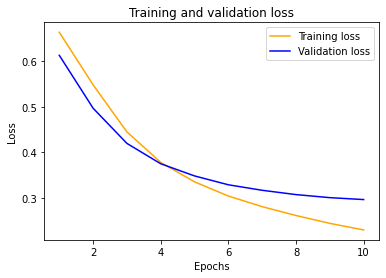

In [30]:
history_dict = history.history
history_dict.keys()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'orange', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()